# Model for detecting movie reviews for IMBD website

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85. It will help viewers to figure out which movie to watch without wasting much time.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

# plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews = df_reviews.dropna()

In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Let's check the number of movies and reviews over years.

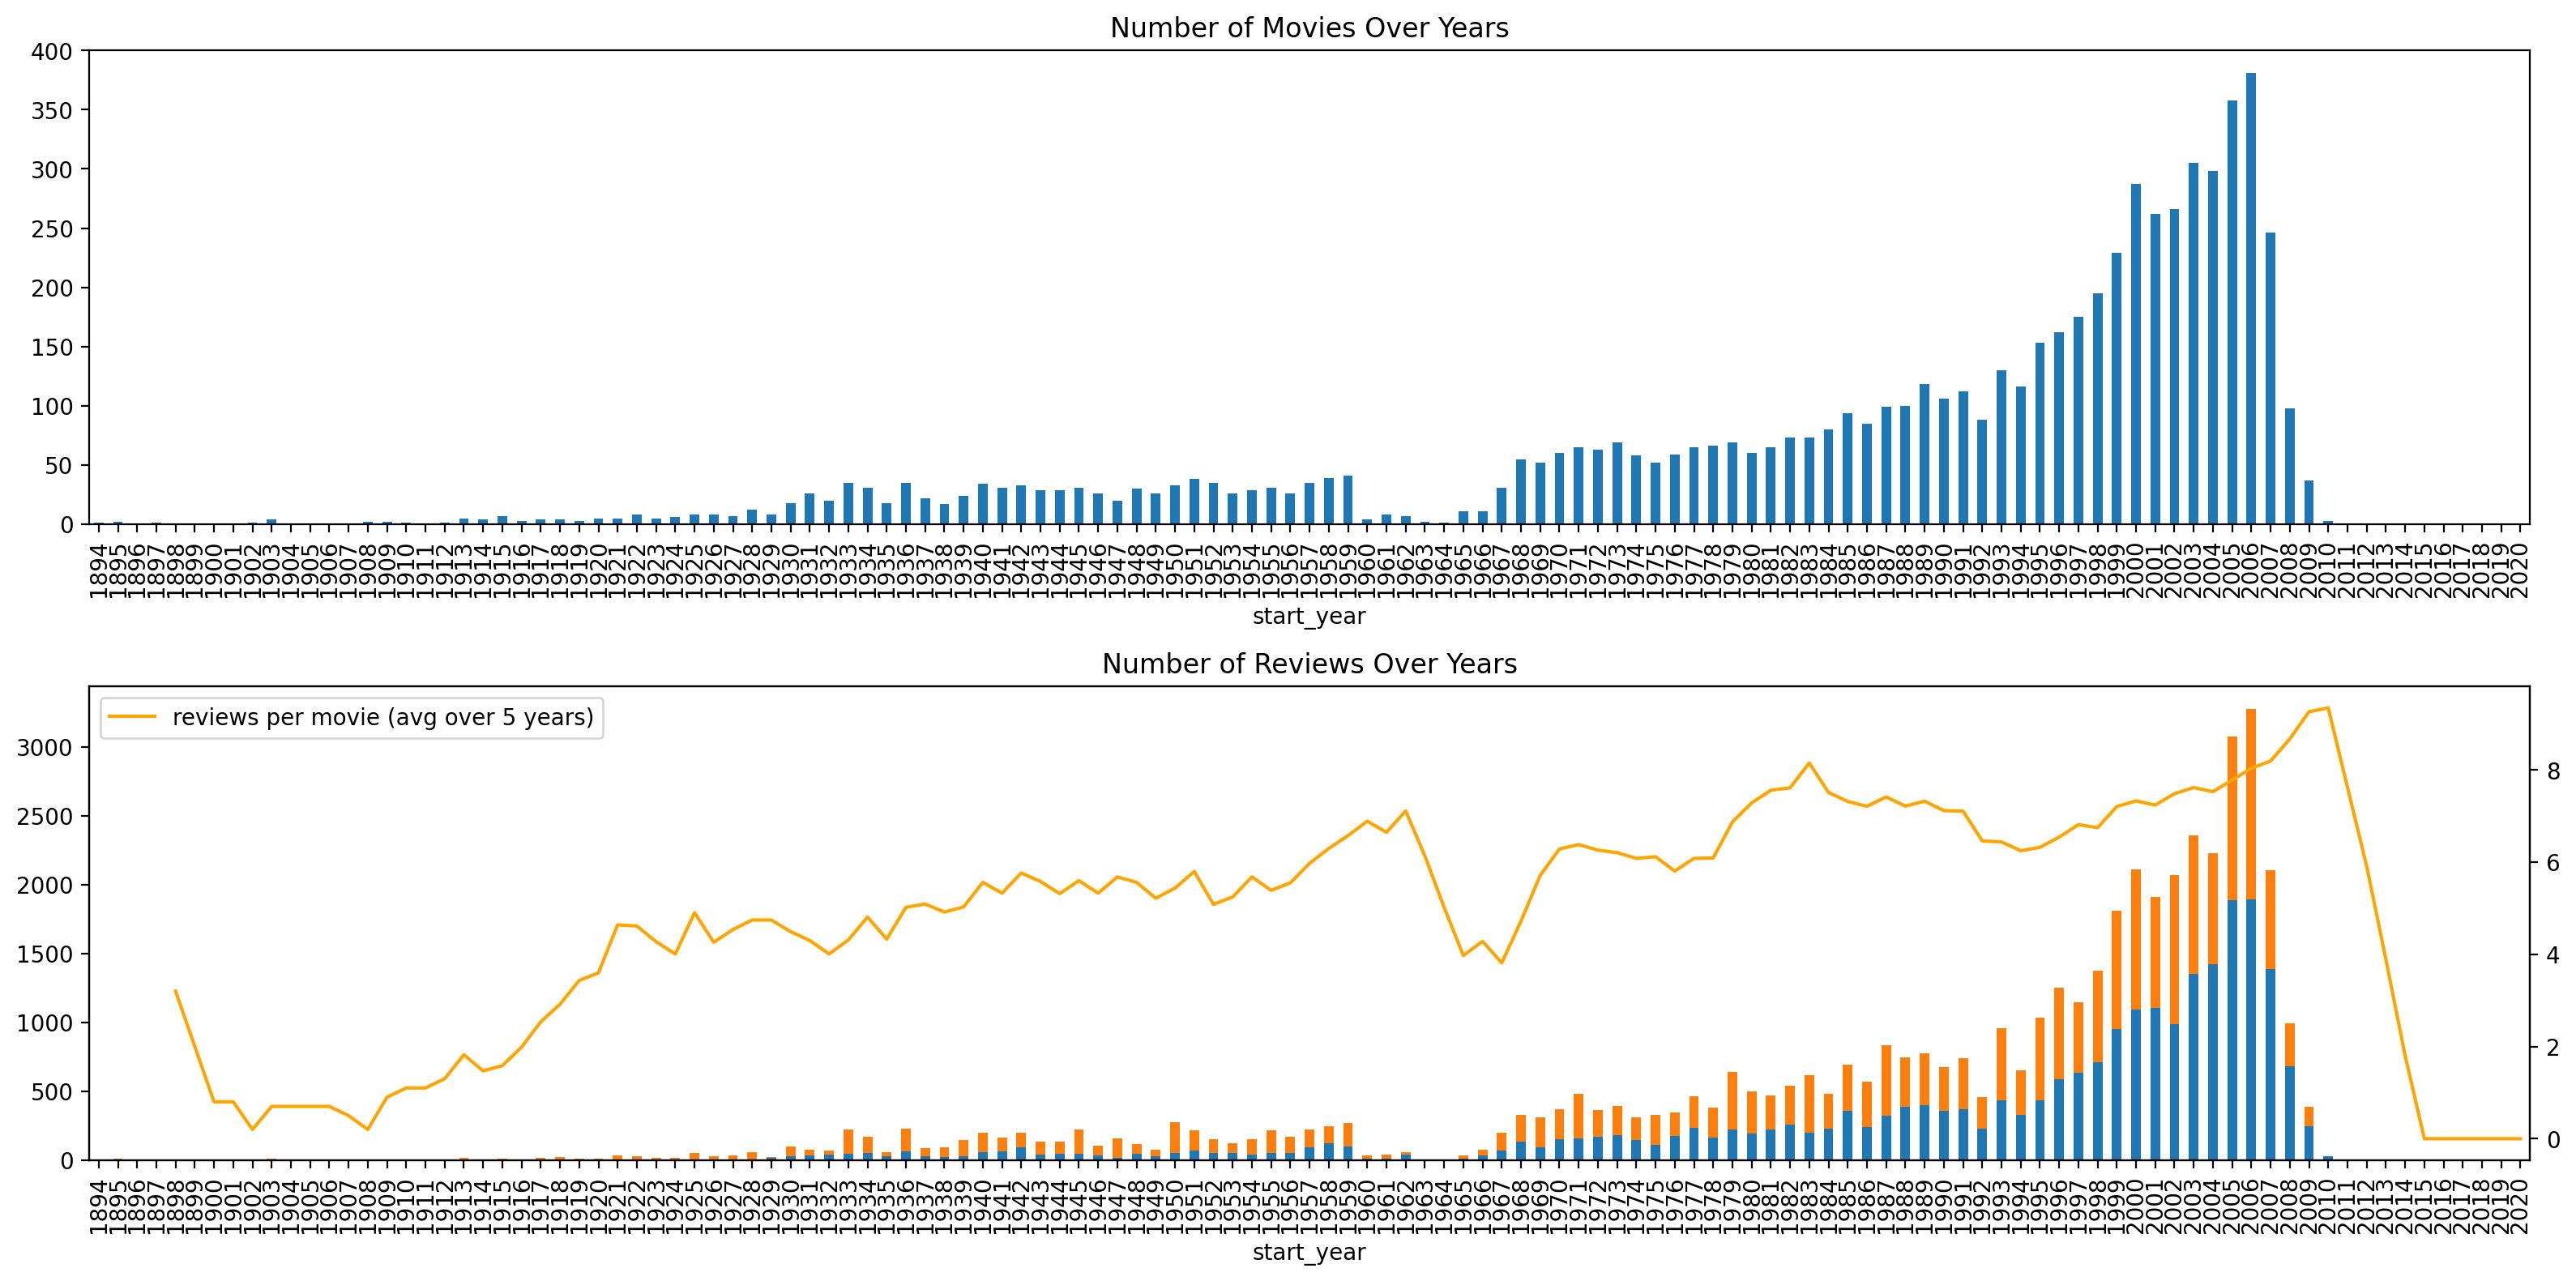

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

### From above graph that number of movies were increasing from 1995 and 2006 was the year for most movies release.
### Second graph shows average reviews per movie over 5 year period and there is a jump noticed in 2000s because of interest or controversy for some movies triggering more reviews.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

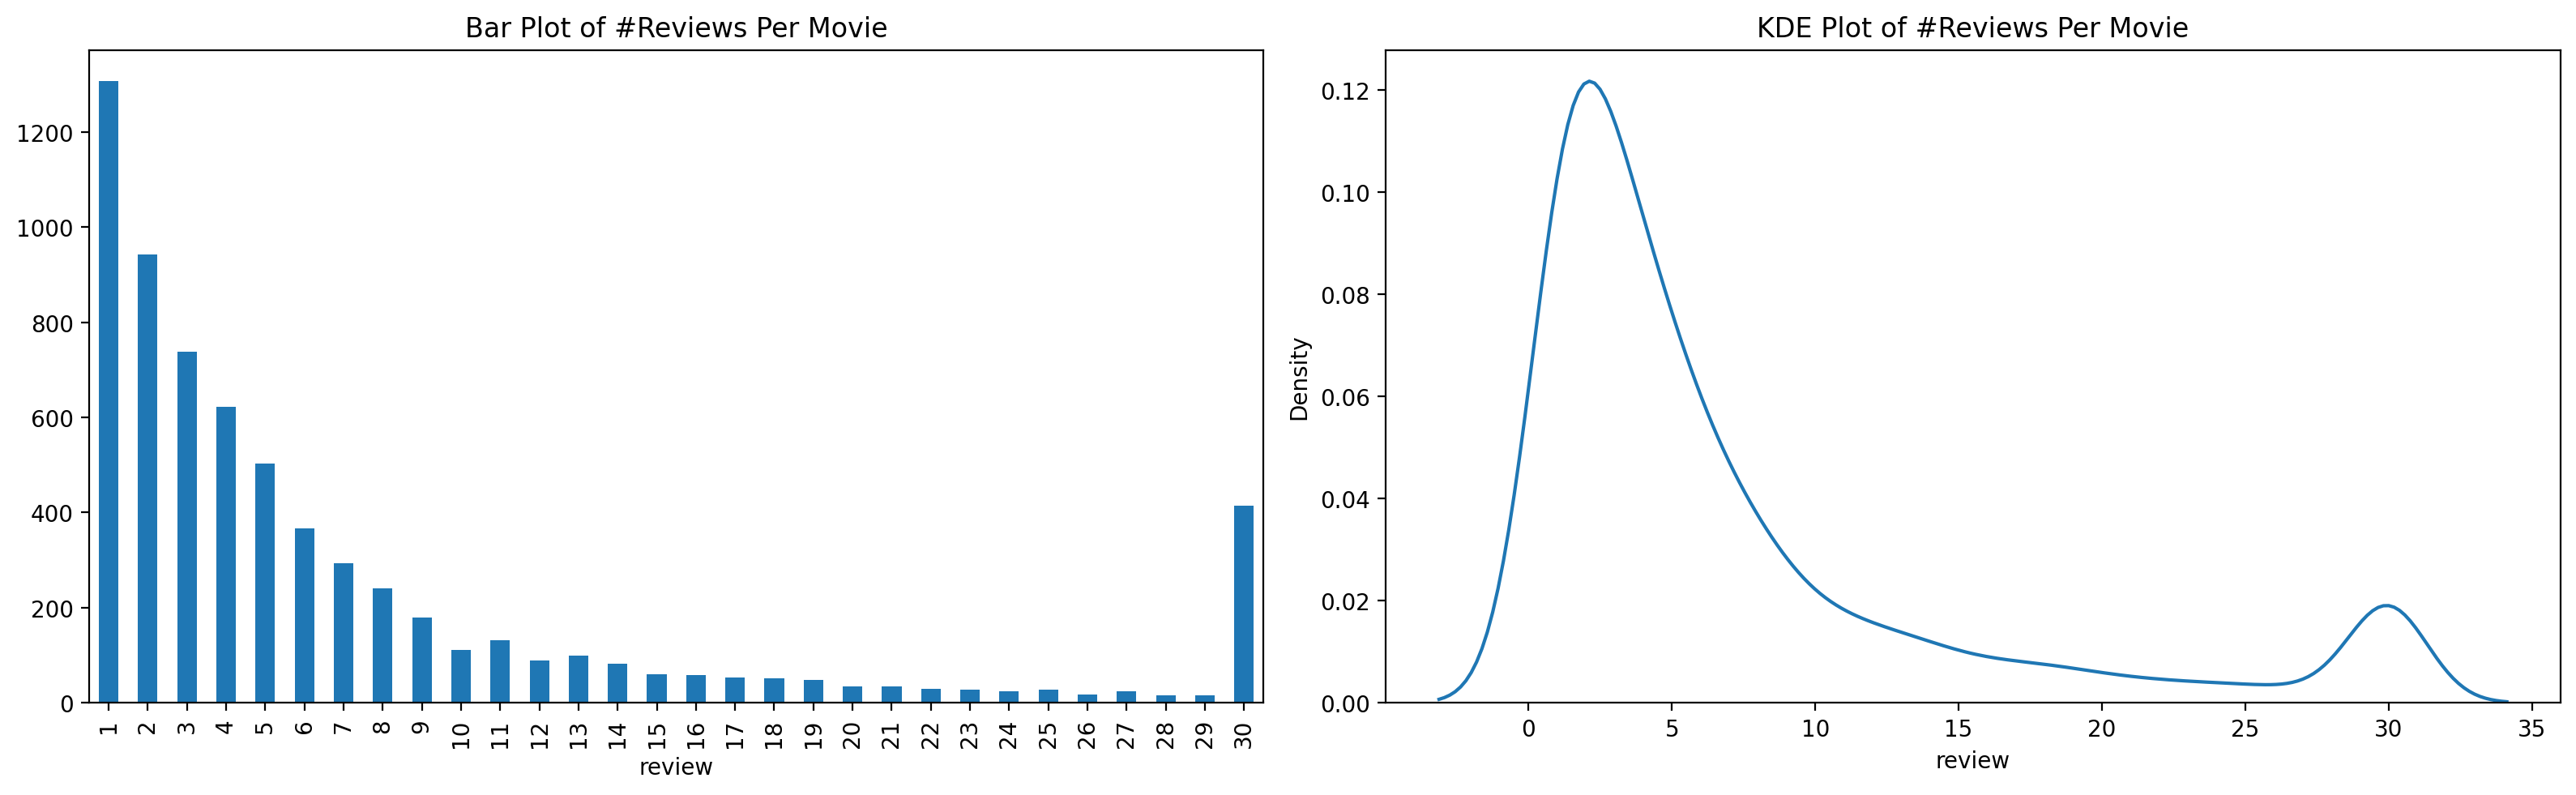

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

### From first graph we did notice that number of movies decreasing as the movie review is increasing. We can see that most movies have 30 reviews.
### Second graph shows that most movies have 2-3 reviews and we also notice a spike at 30 reviews.

In [11]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

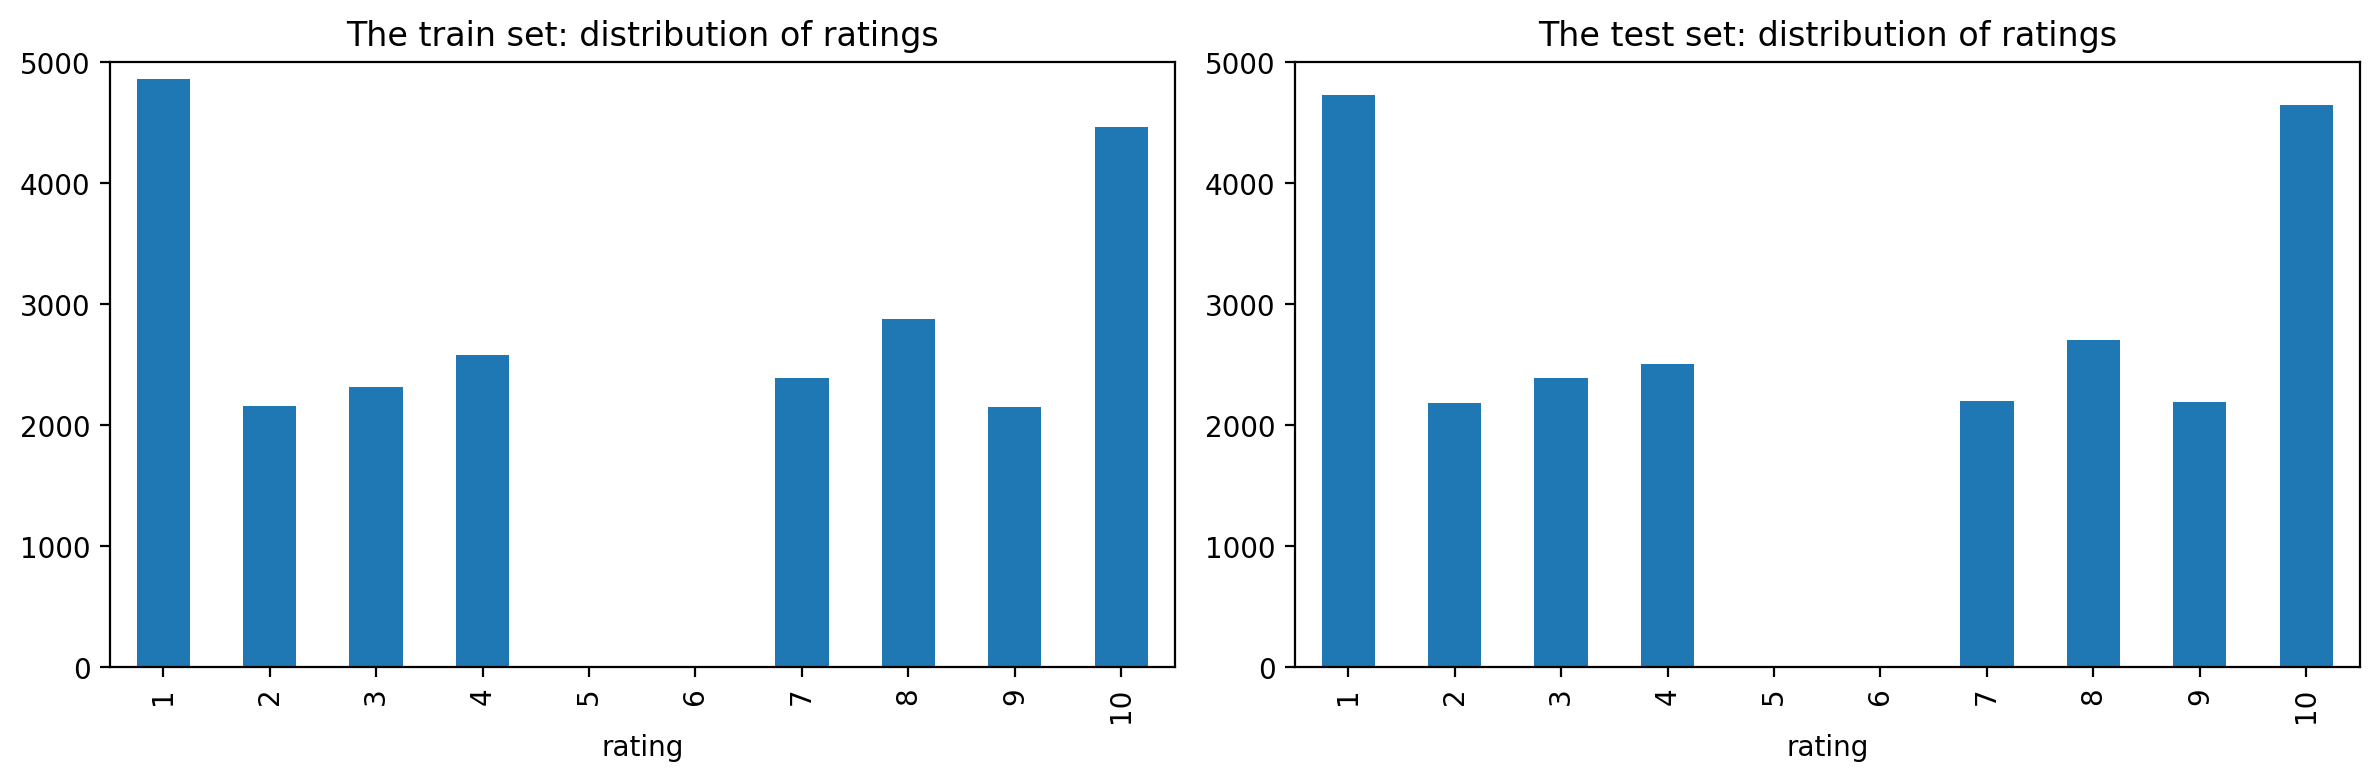

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

### These two graph is showng the distribution of movie ratings in the training set and testing set and both sets look pretty consistent which means the sample for testing data set is similar to the training set which mean the model training has correct sample.

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\Sohin\AppData\Local\Temp\ipykernel_176988\2564148758.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Sohin\AppData\Local\Temp\ipykernel_176988\2564148758.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\Sohin\AppData\Local\Temp\ipykernel_176988\2564148758.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Sohin\AppData\Local\Temp\ipykernel_176988\2564148758.py:31: UserWarning: 

Support f

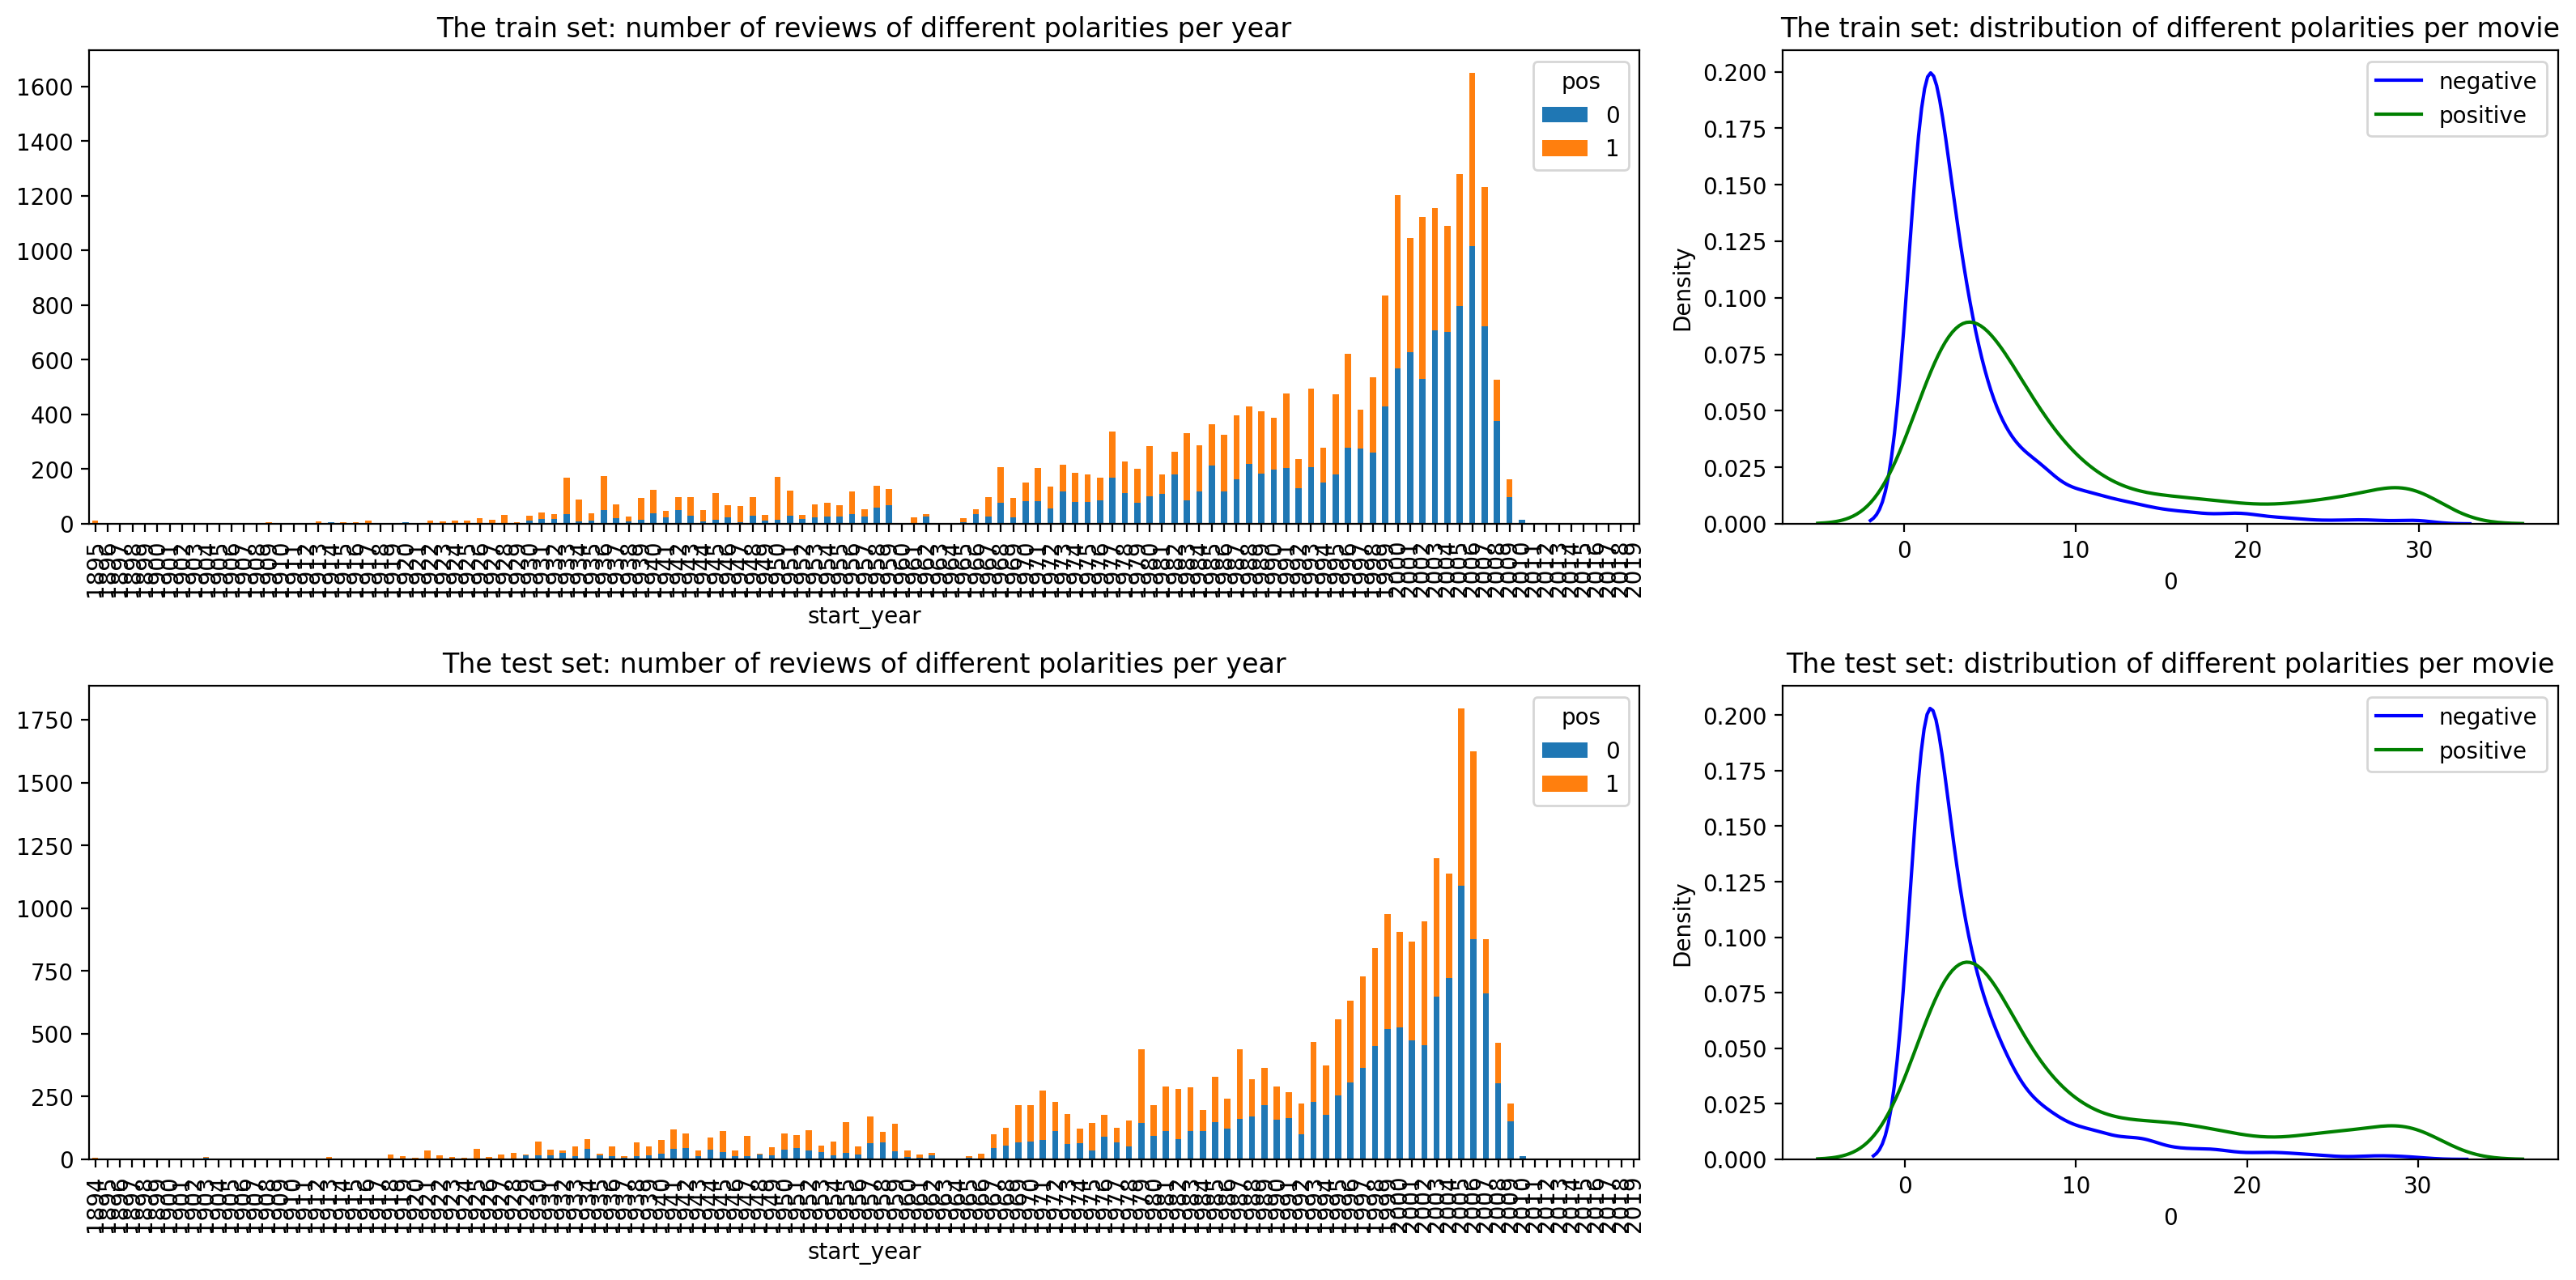

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### In the both graphs we notice a upward trend which could be result of viewers engagement or increased data collection. We can also see that there are more positive reviews than negative reviews.We did notice consistency between training and test data sets whic is important for reliable model evaluation.


## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47329, dtype: object

In [16]:
def review_norm(review):
   # get rid of : 
   review = re.sub(r"[A-Za-z0-9]:", " ", review)
   # get rid of non- standard characters
   review = re.sub(r"[^A-Za-z]", " ", review)
   review = re.sub(r" +", " ", review)
   return review.lower()

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(review_norm)

C:\Users\Sohin\AppData\Local\Temp\ipykernel_176988\3201598096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['review_norm'] = df_reviews['review'].apply(review_norm)


In [18]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i m totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i d say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i ll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

In [19]:
df_reviews['pos']

0        0
1        0
2        0
3        1
4        1
        ..
47326    1
47327    0
47328    1
47329    1
47330    1
Name: pos, Length: 47329, dtype: int64

In [20]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sohin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
lem = WordNetLemmatizer()

def get_lemmas(review):
    lemmas = [lem.lemmatize(word) for word in review.split(" ")]
    lemmatized =" ".join(lemmas)
    return lemmatized 
df_reviews['review_norm'].apply(get_lemmas)

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teen in singa...
4        i m totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbo it spor...
47327    talk about being boring i got this expecting a...
47328    i never thought i d say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i ll make this brief this wa a joy to watch it...
Name: review_norm, Length: 47329, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()
train_features = df_reviews_train.drop(['pos'], axis=1)
test_features = df_reviews_test.drop(['pos'], axis=1)
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [23]:
df_reviews['review'].shape

(47329,)

## Working with models

### Model 0 - Constant

In [24]:
from sklearn.dummy import DummyClassifier


In [25]:

model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_features, train_target)
pred = model_0.predict(test_features)


classification_report_0 = classification_report(test_target, pred)
conf_matrix = confusion_matrix(test_target, pred)
acc = model_0.score(test_features, test_target)
print('Accuracy:', accuracy_score(test_target, pred))

print('\n', classification_report_0)

Accuracy: 0.5015510134704457

               precision    recall  f1-score   support

           0       0.50      1.00      0.67     11803
           1       0.00      0.00      0.00     11730

    accuracy                           0.50     23533
   macro avg       0.25      0.50      0.33     23533
weighted avg       0.25      0.50      0.34     23533



c:\Users\Sohin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sohin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sohin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


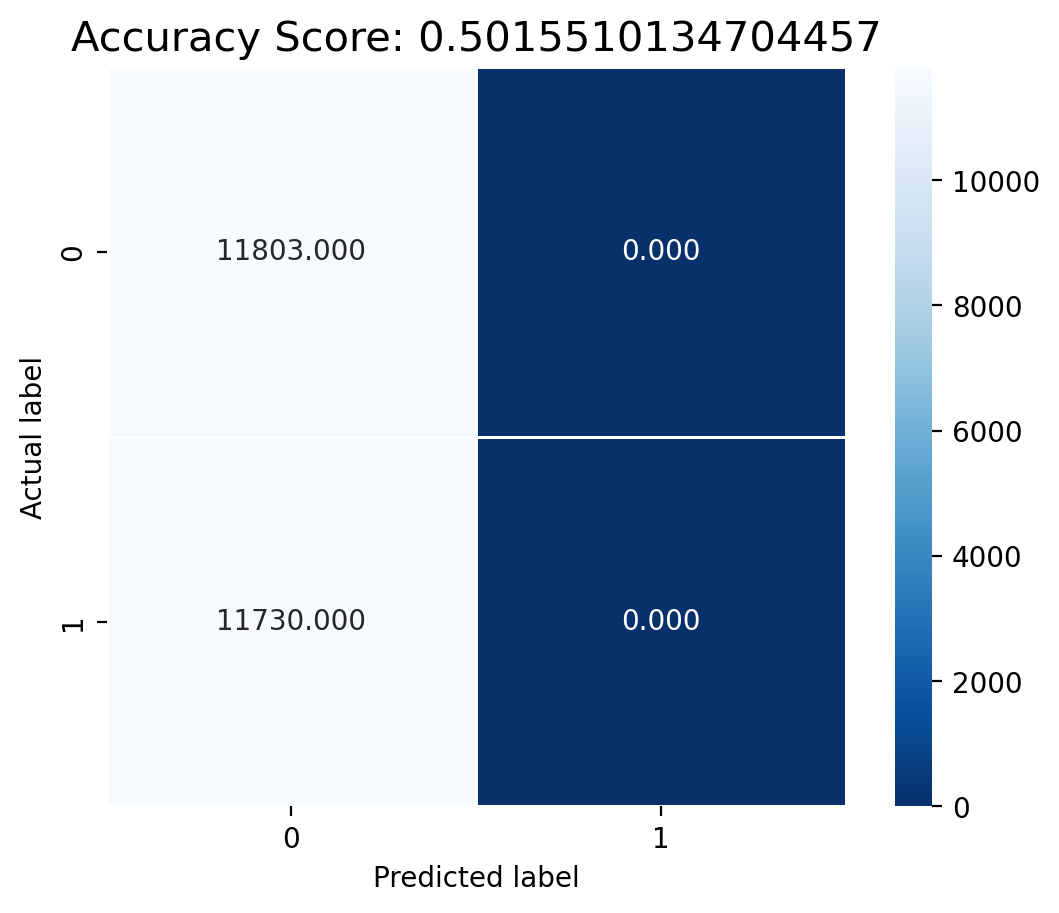

In [26]:
plt.figure(figure=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt='.3f', linewidth=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'. format(acc)
plt.title(all_sample_title, size= 15);

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


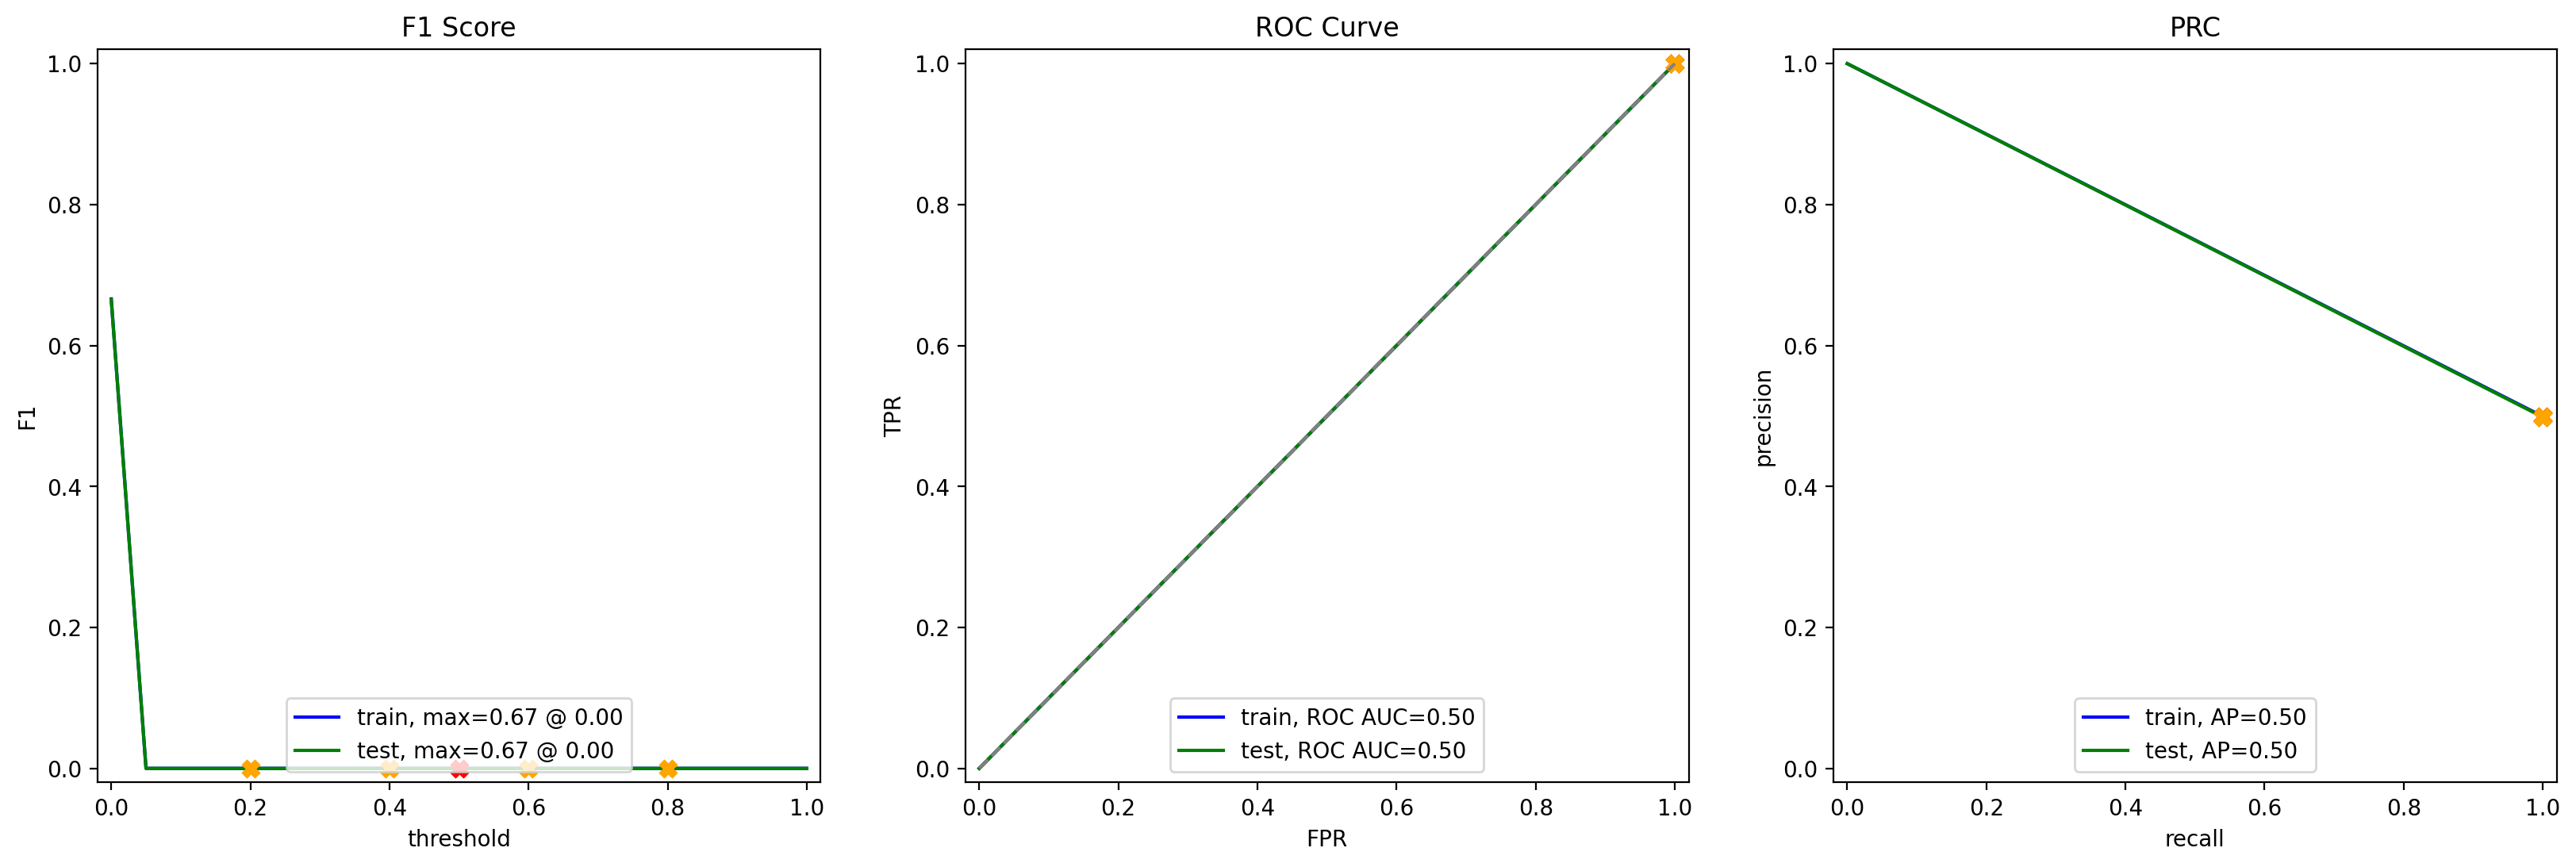

In [27]:
evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Dummy Classifier created a f1 score of 67 and accuracy was 50 % 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [28]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sohin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords

In [30]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
train_target = df_reviews_train['pos']
print(train_features_1.shape)
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
test_target = df_reviews_test['pos']
print(test_features_1.shape)



(23796, 73035)
(23533, 73035)


In [31]:

model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target )

# Ensure x_test is a 2-dimensional array
test_features_1 = test_features_1.reshape(-1, 1) if test_features_1.ndim == 1 else test_features_1

pred_1 = model_1.predict(test_features_1)
classification_report_1 = classification_report(test_target, pred_1)
conf_matrix= confusion_matrix(pred_1, test_target)
acc = model_1.score(test_features_1, test_target)

print('Accuracy:', accuracy_score(test_target, pred_1))

print('\n', classification_report_1)


Accuracy: 0.8828028725619343

               precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11730

    accuracy                           0.88     23533
   macro avg       0.88      0.88      0.88     23533
weighted avg       0.88      0.88      0.88     23533



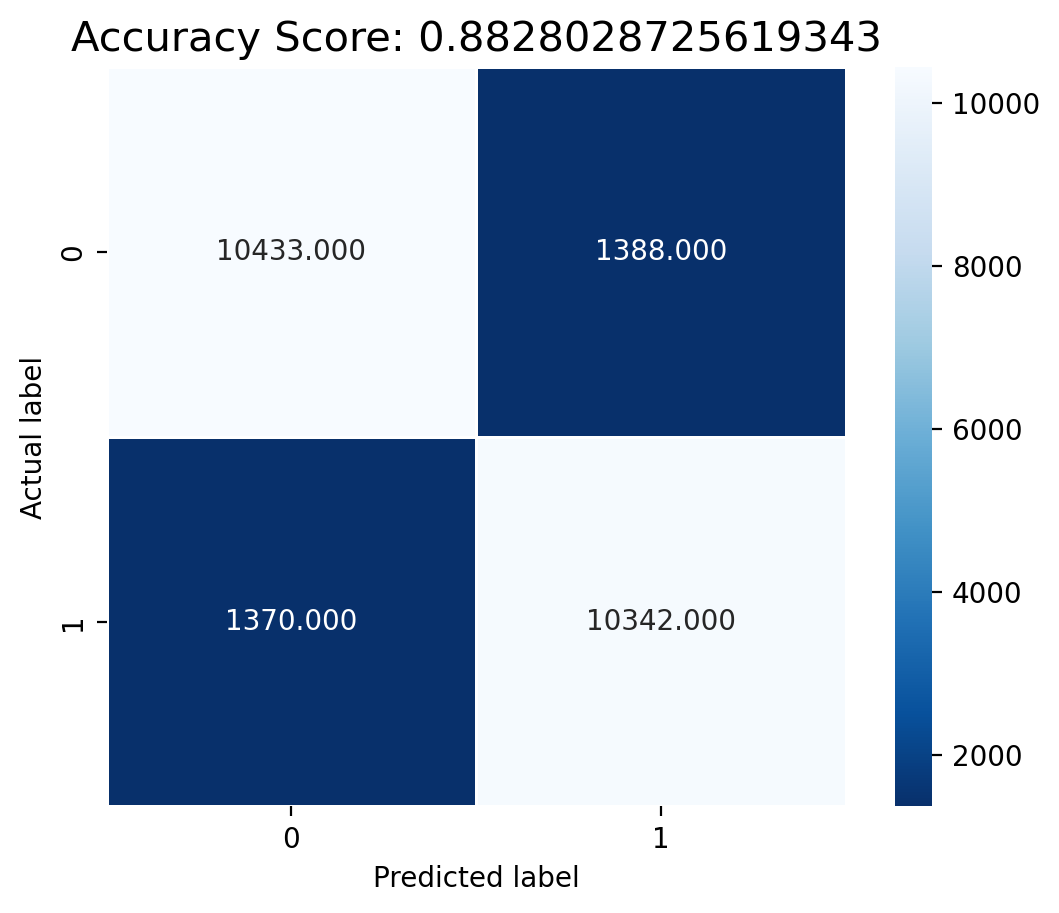

In [32]:
plt.figure(figure=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt='.3f', linewidth=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'. format(acc)
plt.title(all_sample_title, size= 15);

### The model has accuracy of 88% as it detected true negative which are 10433 and true positive of 10342.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


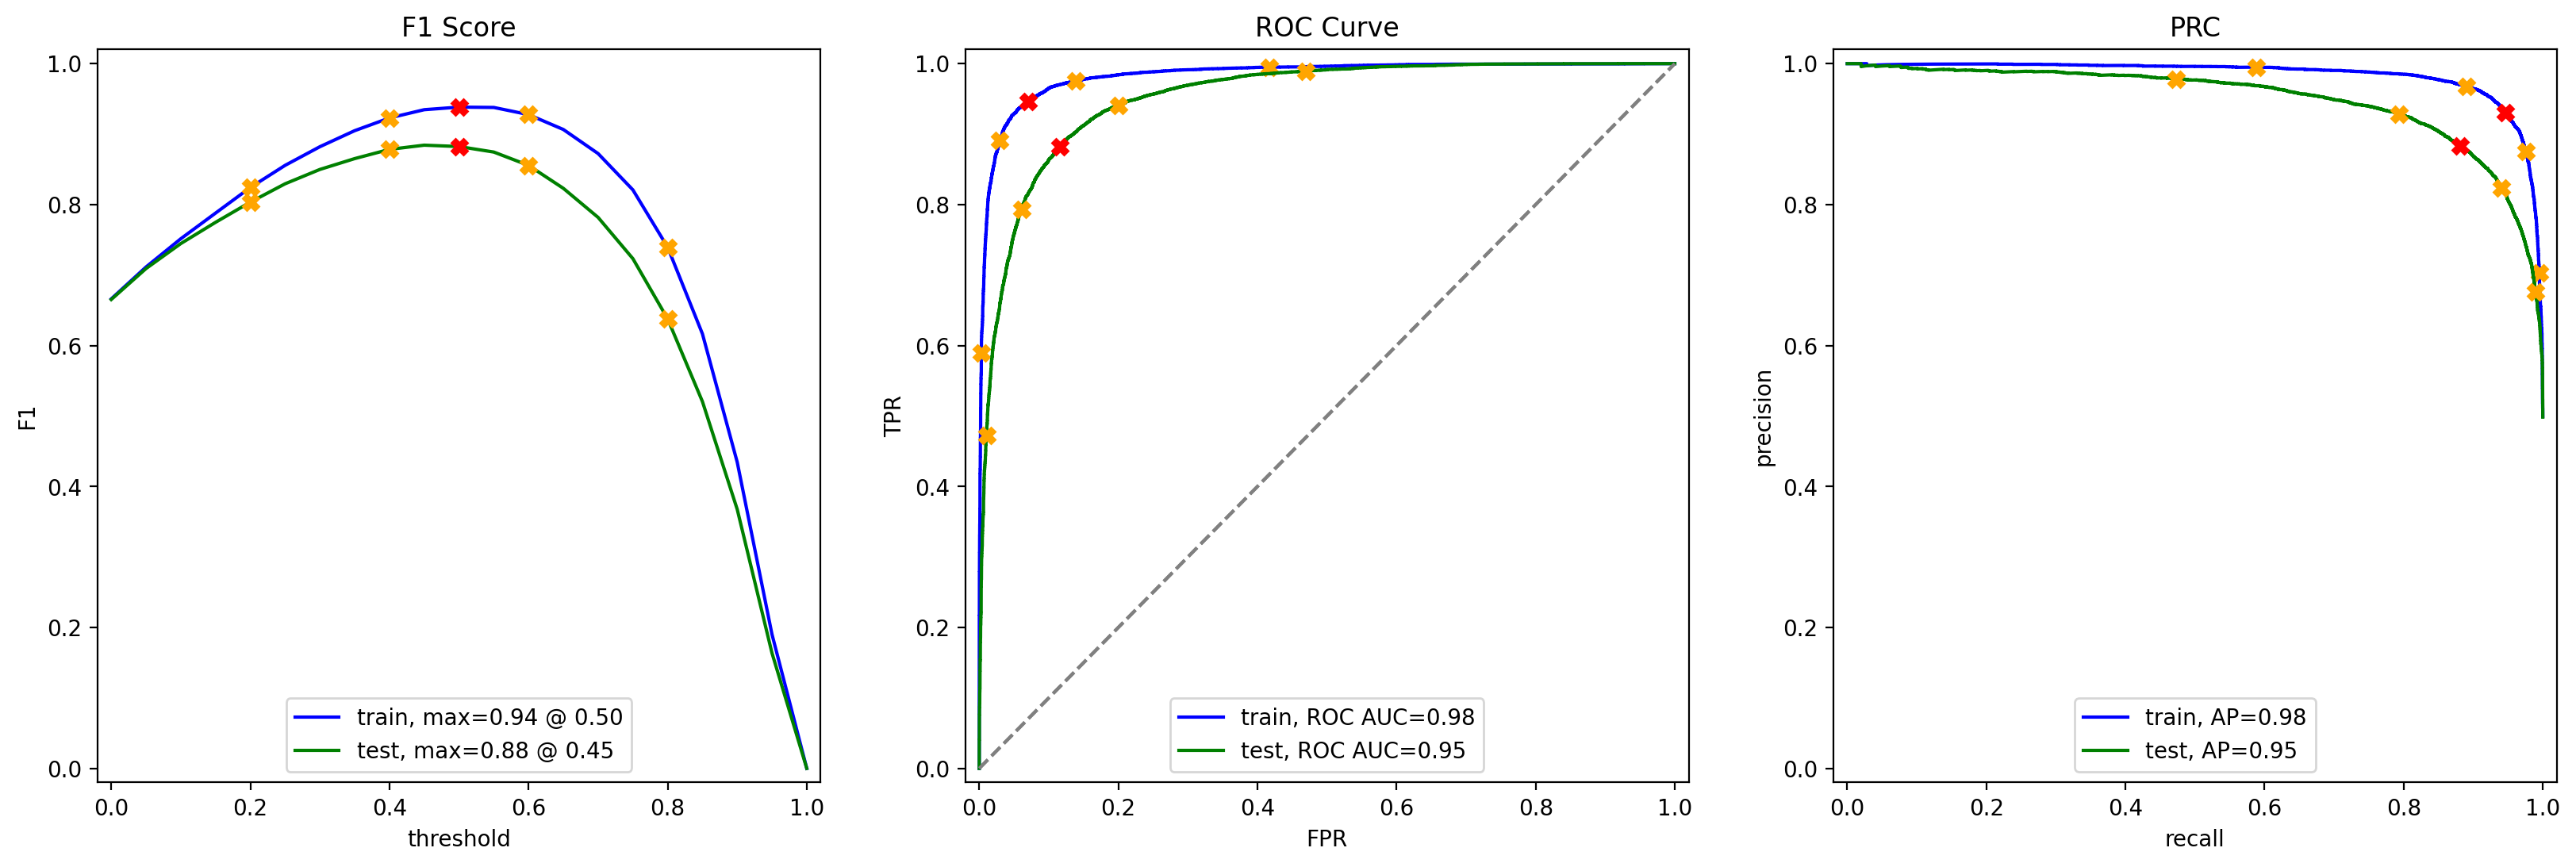

In [33]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Logistic Regression with nltk tool gave a f1 score of 0.88 and accuracy was of 88 % which is pretty efficient for our classification task.

In [34]:
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
train_target = df_reviews_train['pos']
print(train_features_2.shape)
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])
test_target = df_reviews_test['pos']
print(test_features_2.shape)



(23796, 73180)
(23533, 73180)


In [35]:
from sklearn.naive_bayes import MultinomialNB

model_2 = MultinomialNB()
model_2.fit(train_features_2, train_target)
pred_2 = model_2.predict(test_features_2)
classification_report_2 = classification_report(test_target, pred_2)
conf_matrix = confusion_matrix(test_target, pred_2)
acc = model_2.score(test_features_2, test_target)

print('Accuracy:', accuracy_score(test_target, pred_2))

print('\n', classification_report_2)

Accuracy: 0.8276037904219606

               precision    recall  f1-score   support

           0       0.79      0.89      0.84     11803
           1       0.87      0.77      0.82     11730

    accuracy                           0.83     23533
   macro avg       0.83      0.83      0.83     23533
weighted avg       0.83      0.83      0.83     23533



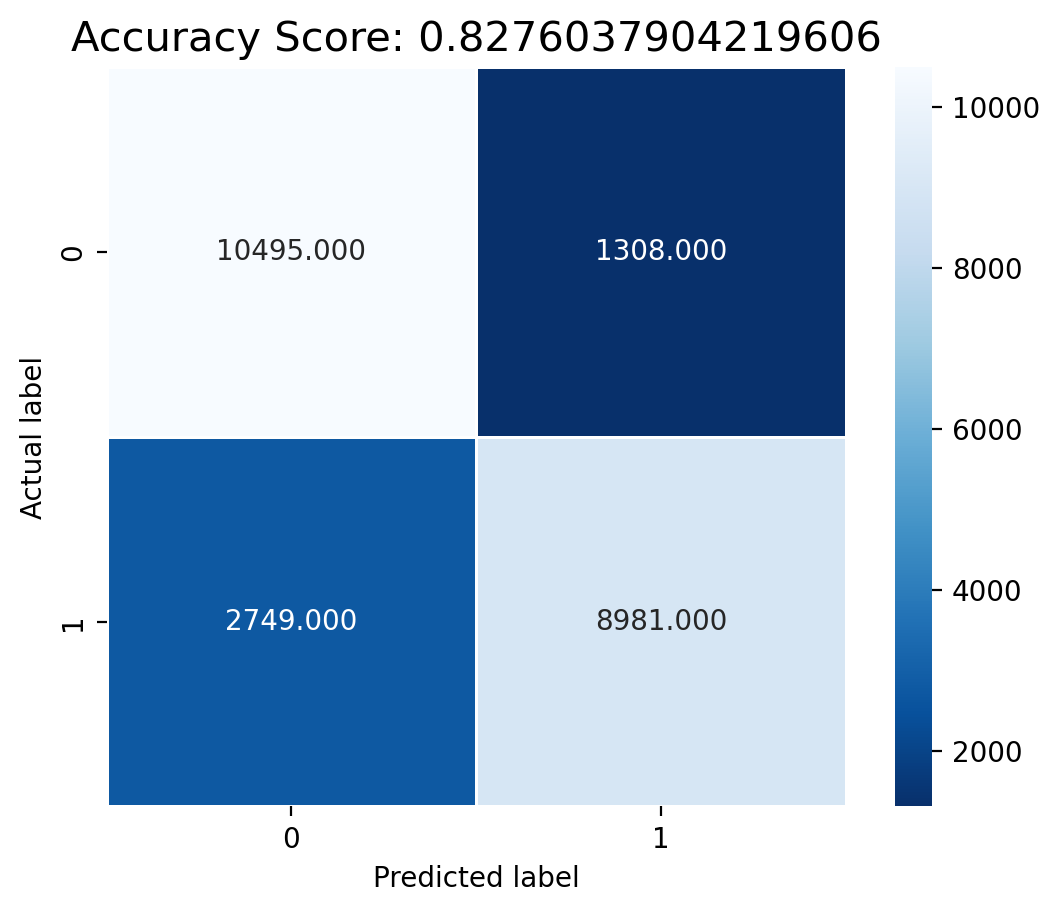

In [36]:
plt.figure(figure=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt='.3f', linewidth=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'. format(acc)
plt.title(all_sample_title, size= 15);

### The model has accuracy of 82% as it detected true negative which are 10495 and true positive of 8981.

          train  test
Accuracy   0.91  0.83
F1         0.91  0.82
APS        0.97  0.91
ROC AUC    0.97  0.92


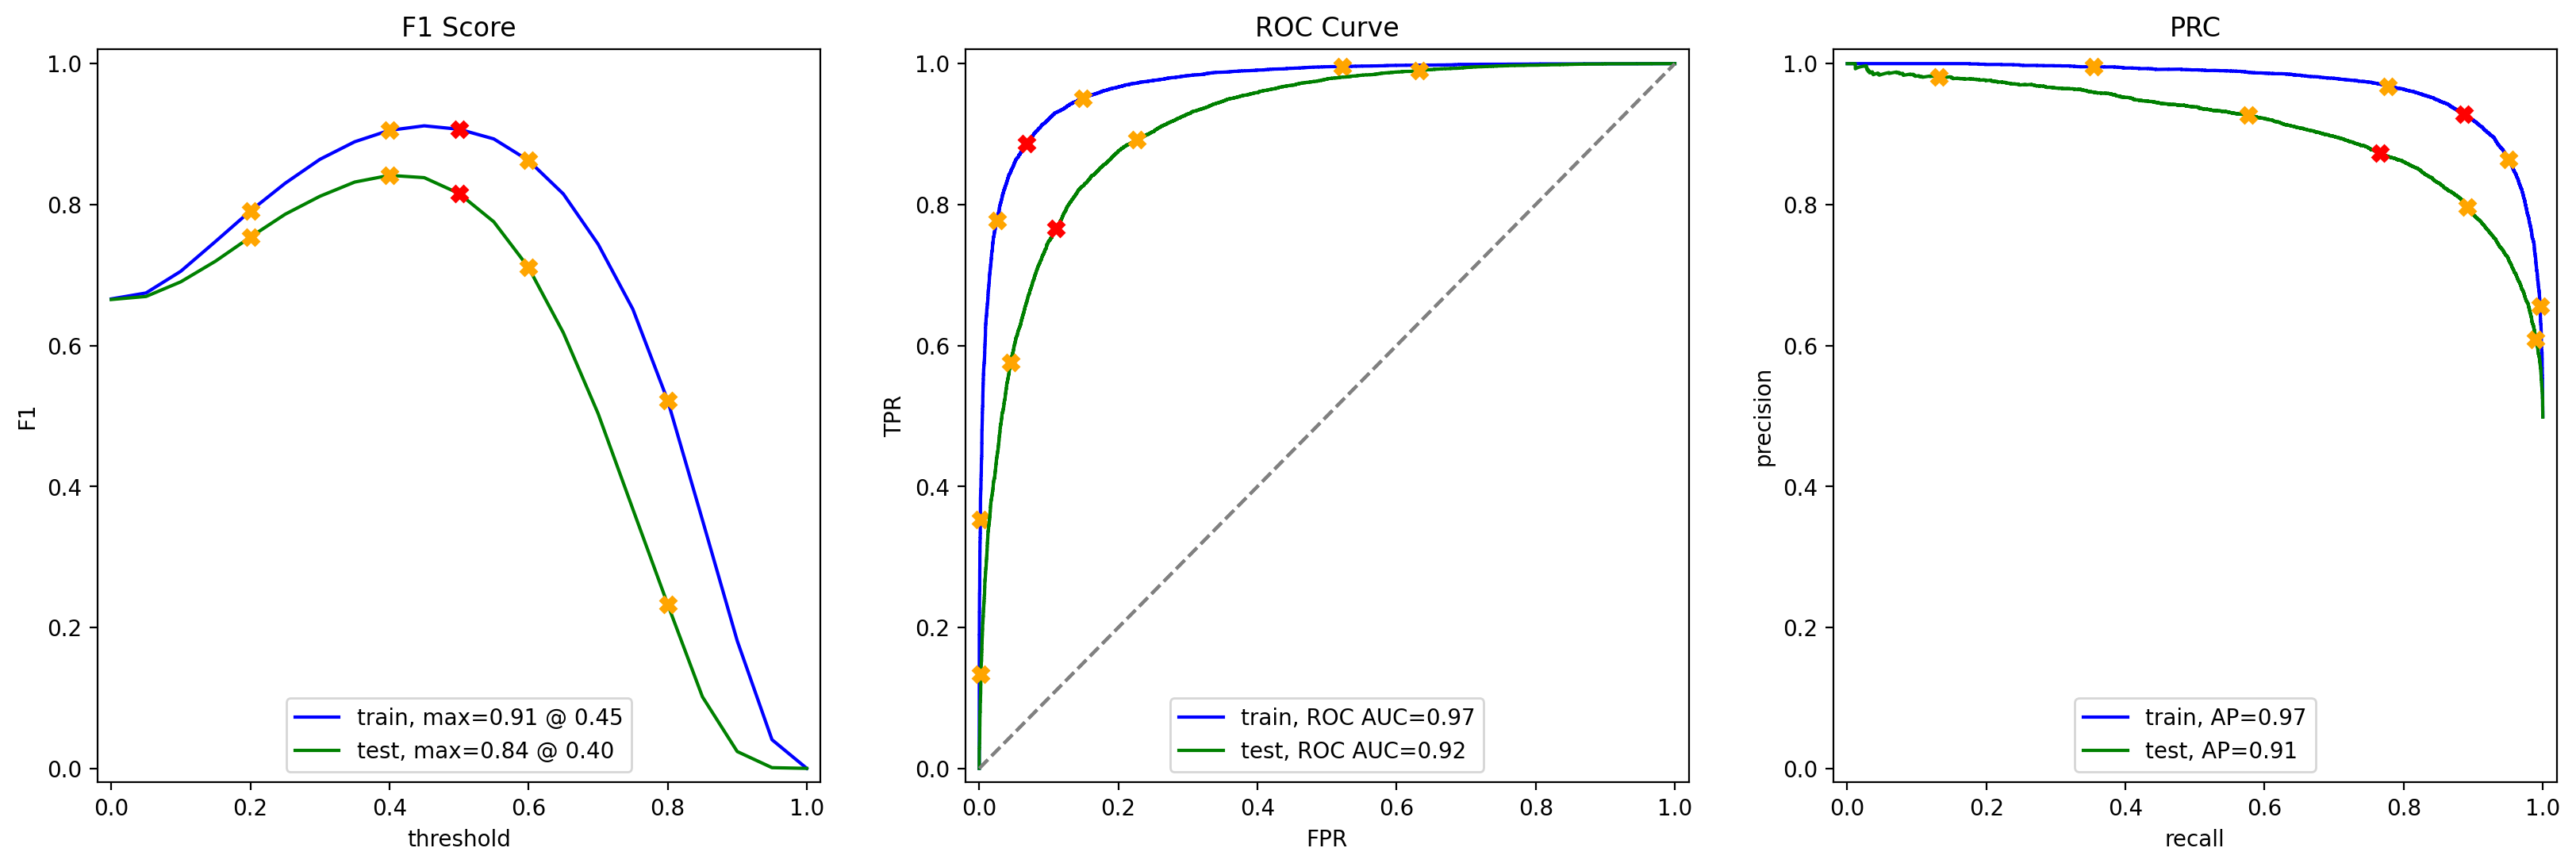

In [37]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)


###  MultinomialNB model has accuracy of 83% anf f1 score of 0.82 which is below expectation for this classification task.

### Model 3 - spaCy, TF-IDF and LR

In [38]:
import spacy
from sklearn.linear_model import LogisticRegression
import random
from sklearn.pipeline import Pipeline
from transformers import pipeline, AutoModel, AutoTokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [39]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)



In [ ]:
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

In [ ]:
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
print(train_features_3.shape)
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])
print(test_features_3.shape)

(23796, 60670)
(23533, 60670)


In [ ]:

model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

pred_3 = model_3.predict(test_features_3)

pred_3_binary = (pred_3 >= 0.5).astype(int)

classification_report_3 = classification_report(test_target, pred_3_binary)
conf_matrix= confusion_matrix(pred_3_binary, test_target)
acc = model_3.score(test_features_3, test_target)

print('Accuracy:', accuracy_score(test_target, pred_3_binary))

print('\n', classification_report_3)

Accuracy: 0.88097565121319

               precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11730

    accuracy                           0.88     23533
   macro avg       0.88      0.88      0.88     23533
weighted avg       0.88      0.88      0.88     23533



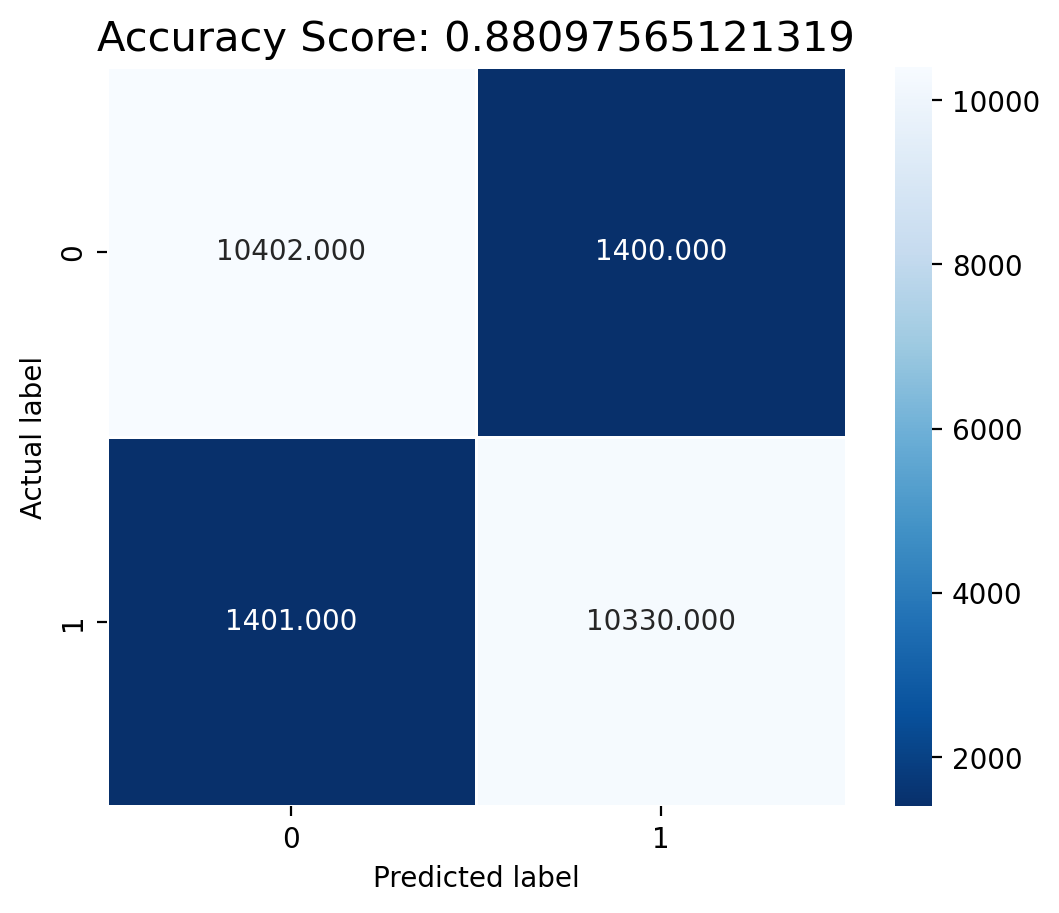

In [ ]:
plt.figure(figure=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt='.3f', linewidth=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'. format(acc)
plt.title(all_sample_title, size= 15);

### The model has accuracy of 88% and the model detected false negative around 1401 instances and false positive around 1400.

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


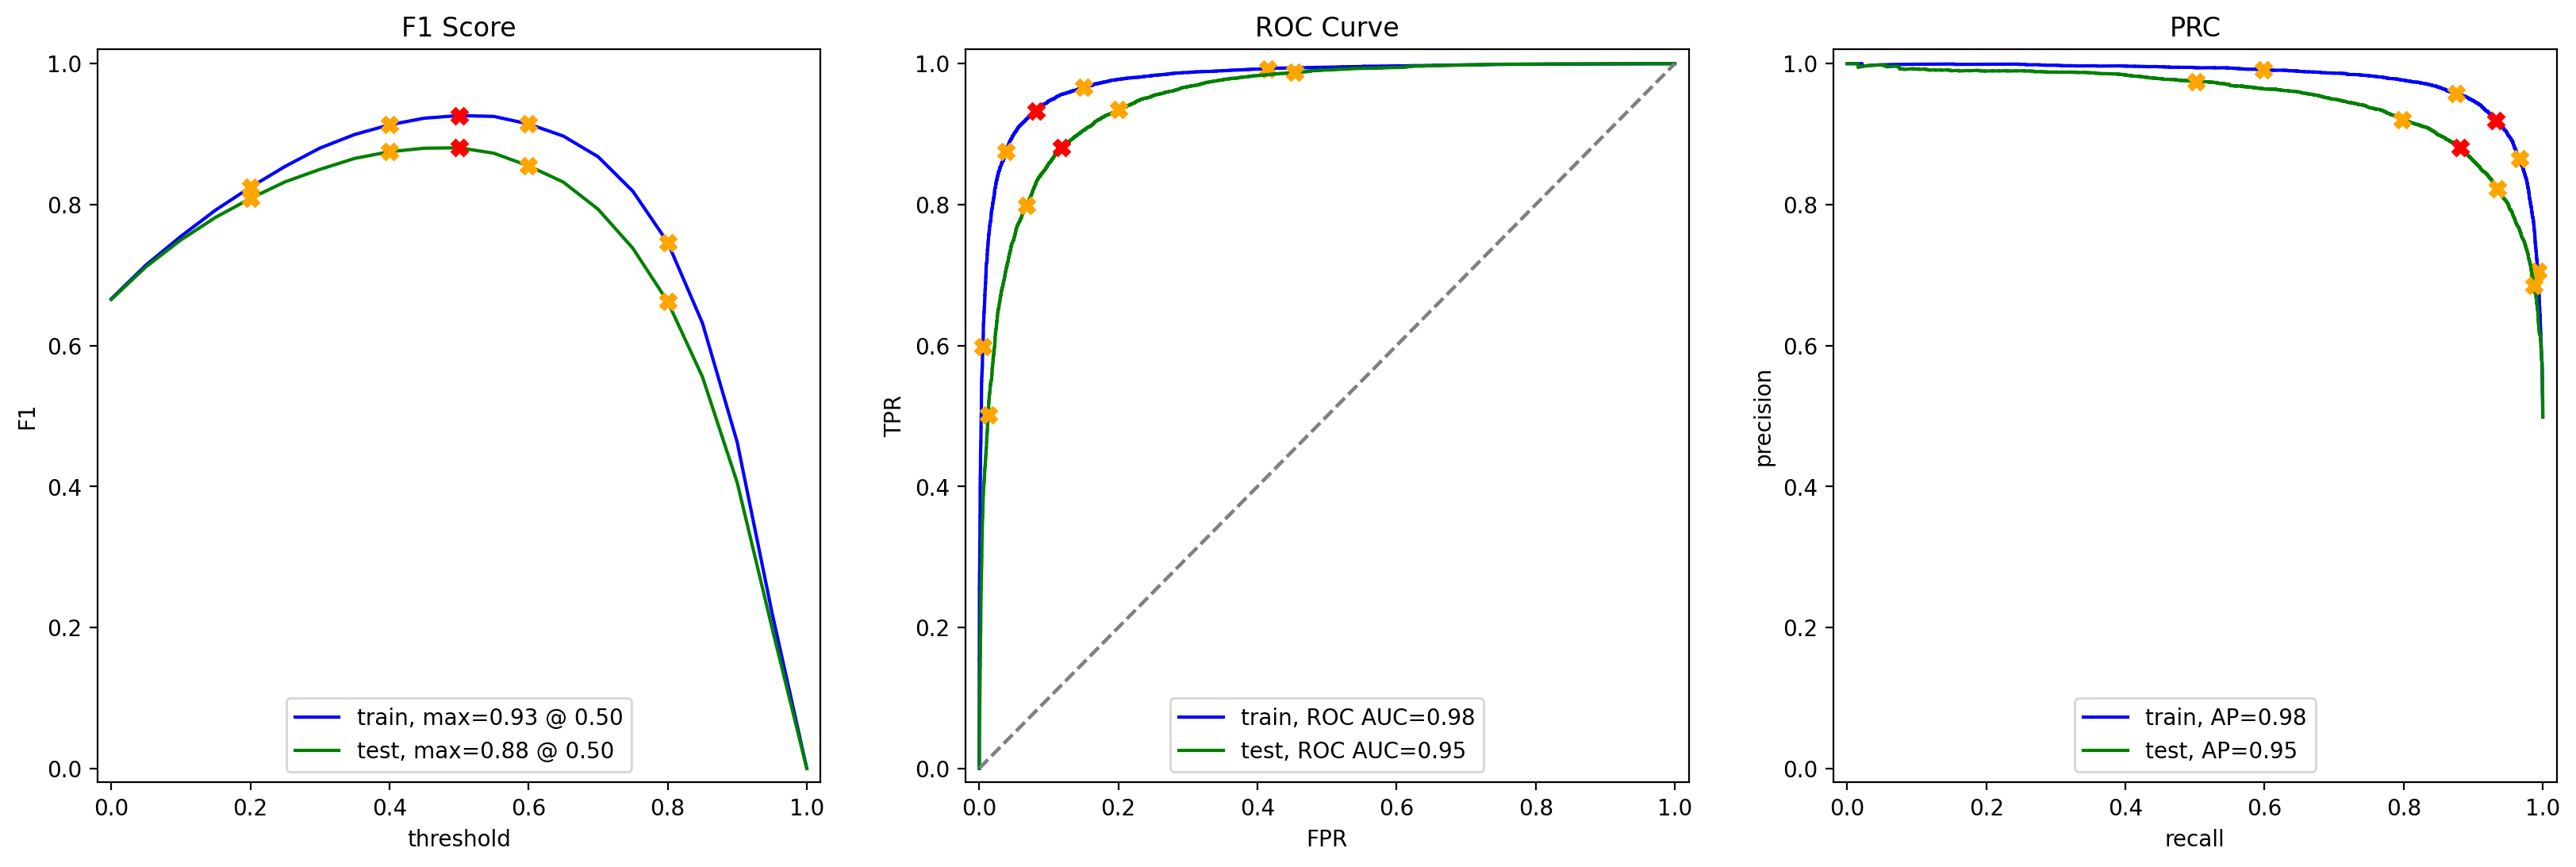

In [ ]:
evaluate_model(model_3,train_features_3,train_target, test_features_3, test_target)

### Logistic Regression model with spaCY gave accuracy of 88% anf f1 score of 0.88.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
model_4 = LGBMClassifier()
model_4.fit(train_features_3, train_target)

pred_4 = model_4.predict(test_features_3)

pred_4_binary = (pred_4 >= 0.5).astype(int)

classification_report_4 = classification_report(test_target, pred_4_binary)
conf_matrix= confusion_matrix(pred_4_binary, test_target)
acc = model_4.score(test_features_3, test_target)

print('Accuracy:', accuracy_score(test_target, pred_4_binary))

print('\n', classification_report_4)

c:\Users\sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484201
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9510
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
Accuracy: 0.8601113330217142

               precision    recall  f1-score   support

           0       0.87      0.85      0.86     11803
           1       0.85      0.87      0.86     11730

    accuracy                           0.86     23533
   macro avg       0.86      0.86      0.86     23533
weighted avg       0.86      0.86      0.86     23533



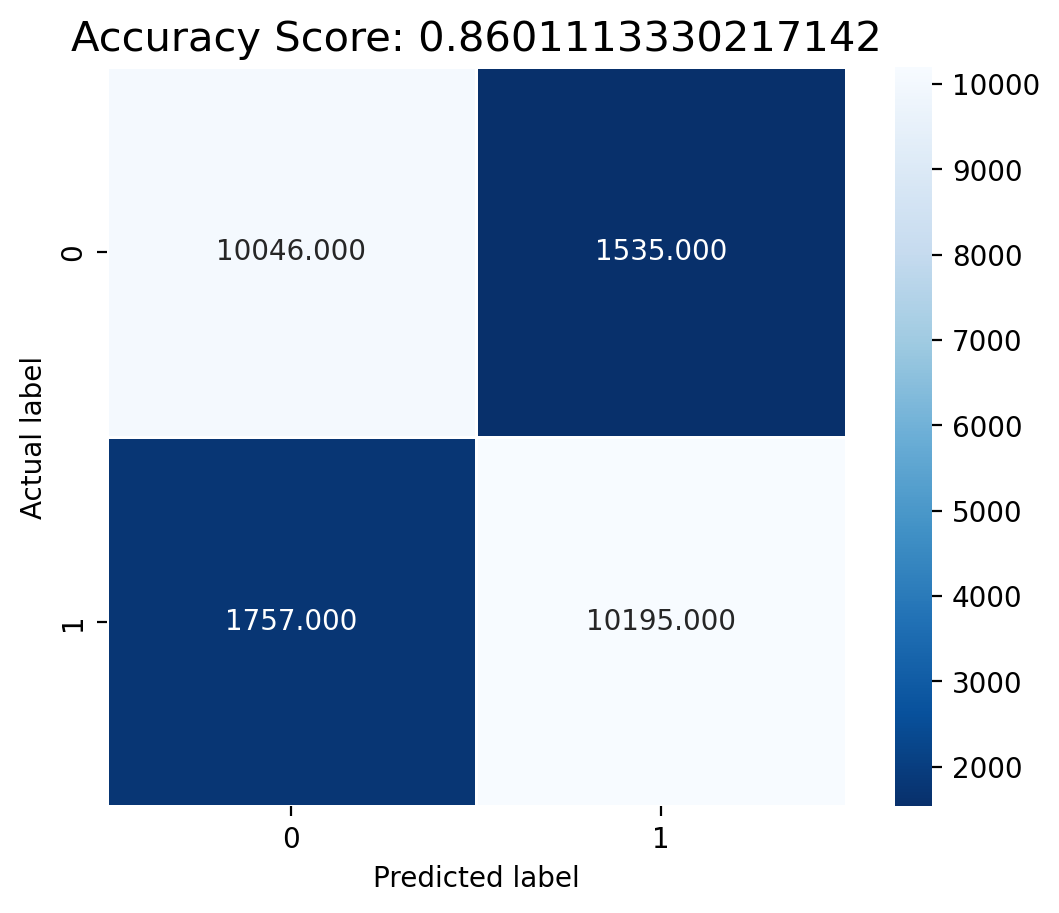

In [ ]:
plt.figure(figure=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt='.3f', linewidth=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'. format(acc)
plt.title(all_sample_title, size= 15);

 ### The model has accuracy of 86% and model correctly predicted 10195 positives and 10046 negative reviews.

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


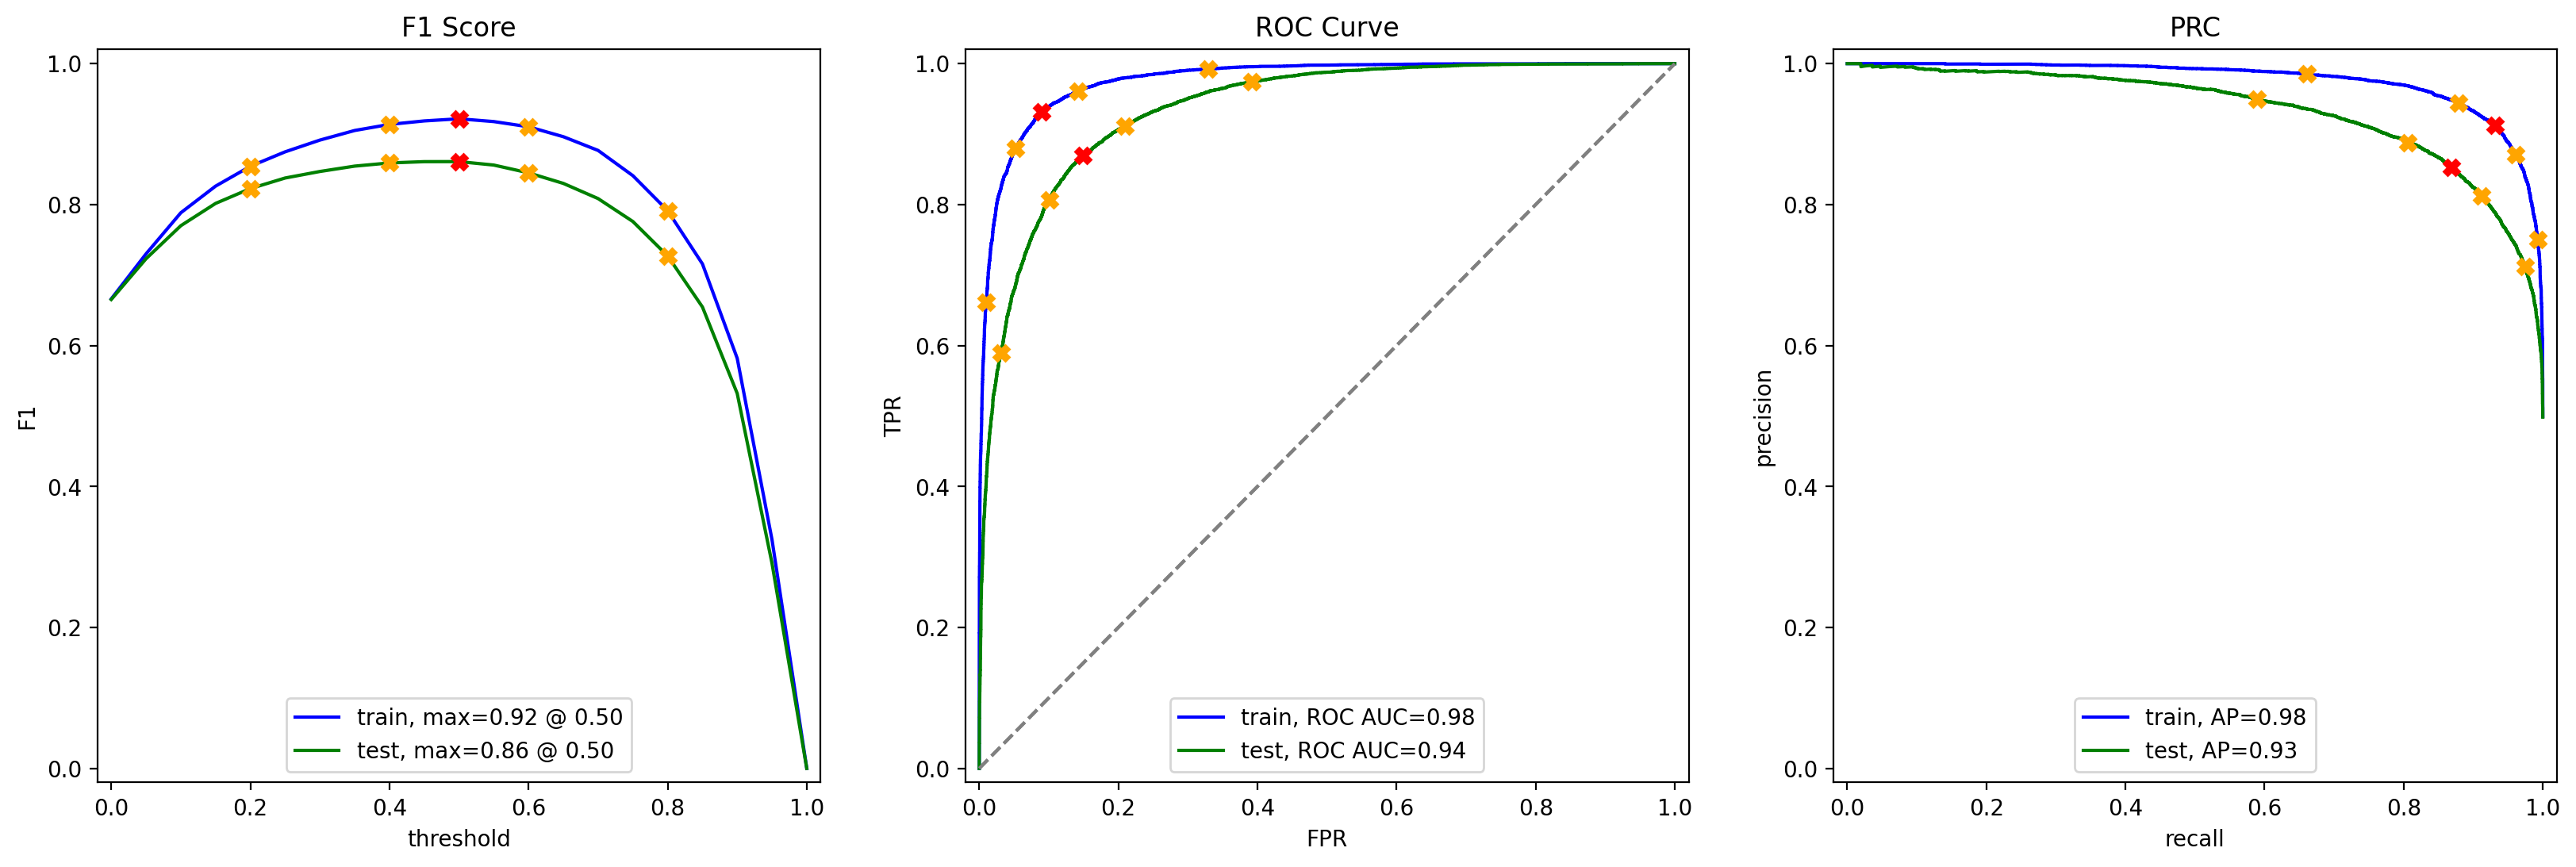

In [ ]:
evaluate_model(model_4, train_features_3,train_target, test_features_3, test_target)

 ### The LightLGBM model has accuracy of 86% and f1 score of 0.86

## My Review

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] =  my_reviews['review'].apply(review_norm)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


## Model 1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie 
0.15:  well i was bored and felt asleep in the middle of the movie 
0.53:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Logistic regression was used with nltk and we can notice  that bad reviews scoring under 50 and good one over 50.

## Model 2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.36:  i did not simply like it not my kind of movie 
0.20:  well i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didn t expect the reboot to be so good writers really cared about the source material
0.40:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.60:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo



### MultinomialNB model was used to create the above sentiment analysis.

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie 
0.23:  well i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didn t expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### When Logistic Regression was used with Nltk and spaCy it was noticed that first output scored 14 via nltk but first output scored 21 via spaCy. It is still negative sentimate but scoring changed a little as spaCy predited it little better because it is negative review but it is not because the viewer thought it is bad movie but he or she does not like movies like this.

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.63:  i did not simply like it not my kind of movie 
0.49:  well i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.57:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn t expect the reboot to be so good writers really cared about the source material
0.76:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.23:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


While looking at the results I can say that the model is working good as I can say the sentiment analysis. As I can see by the output that whereever I see a positive review the score is more than 50 and where there is negative it is under 40.

## Conclusions

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. 
The goal is to train a model to automatically detect negative reviews.
 You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

First of all the punctuations, white spaces were removed  and the text was converted into lowercase so that there is less confusion with uppercases.
Different model were trained as Dummy Classifier, Logistic Regression, MultinomialNB, Light GBM Classifier.
The best model which gave a f1 score of 0.88 was Logistic Regression and f1 score of 0.86 was achived by Light GBM Classifier.
The other models gave a f1 score lower than the expectation of 0.85 f1 score. 

Logistic Regression performed outstanding at this project because it was binary classification task where we need to look into the prediction of positive of negative reviews
by denoting 0 for negative nad 1 for positive.
As the dataset was moderate sized so logistic regression performed well. It cannot handle very large datasets or very small datasets that efficiently.

The machine learning model work perfectly on the new dataframe.
